# Discretization

The aim of the notebook is to evaluate the performance of CategoricalHMM on discretized data

In [1]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import urllib
import itertools
from scipy.stats import multivariate_normal
from source.model.discretized_HMM import DiscreteHMM, DISCRETIZATION_TECHNIQUES

In [2]:
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
# sns.set_context("talk")

# https://xkcd.com/color/rgb/

with urllib.request.urlopen('https://xkcd.com/color/rgb.txt') as f:
    colors = f.readlines()
color_names = [str(c)[2:].split('\\t')[0] for c in colors[1:]]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
colors

[(0.6745098039215687, 0.7607843137254902, 0.8509803921568627),
 (0.33725490196078434, 0.6823529411764706, 0.3411764705882353),
 (0.6980392156862745, 0.6, 0.43137254901960786),
 (0.6588235294117647, 1.0, 0.01568627450980392),
 (0.4117647058823529, 0.8470588235294118, 0.30980392156862746),
 (0.5372549019607843, 0.27058823529411763, 0.5215686274509804),
 (0.4392156862745098, 0.6980392156862745, 0.24705882352941178),
 (0.8313725490196079, 1.0, 1.0),
 (0.396078431372549, 0.6705882352941176, 0.48627450980392156),
 (0.5843137254901961, 0.1803921568627451, 0.5607843137254902),
 (0.9882352941176471, 0.9882352941176471, 0.5058823529411764),
 (0.6470588235294118, 0.6392156862745098, 0.5686274509803921),
 (0.2196078431372549, 0.5019607843137255, 0.01568627450980392),
 (0.2980392156862745, 0.5647058823529412, 0.5215686274509804),
 (0.3686274509803922, 0.6078431372549019, 0.5411764705882353),
 (0.9372549019607843, 0.7058823529411765, 0.20784313725490197),
 (0.8509803921568627, 0.6078431372549019, 0.5098039215686274),
 (0.0392156862745098, 0.37254901960784315, 0.2196078431372549),
 (0.047058823529411764, 0.023529411764705882, 0.9686274509803922),
 (0.3803921568627451, 0.8705882352941177, 0.16470588235294117),
 (0.21568627450980393, 0.47058823529411764, 0.7490196078431373),
 (0.13333333333333333, 0.25882352941176473, 0.7803921568627451),
 (0.3254901960784314, 0.23529411764705882, 0.7764705882352941),
 (0.6078431372549019, 0.7098039215686275, 0.23529411764705882),
 (0.0196078431372549, 1.0, 0.6509803921568628),
 (0.12156862745098039, 0.38823529411764707, 0.3411764705882353),
 (0.00392156862745098, 0.45098039215686275, 0.4549019607843137),
 (0.047058823529411764, 0.7098039215686275, 0.4666666666666667),
 (1.0, 0.027450980392156862, 0.5372549019607843),
 (0.6862745098039216, 0.6588235294117647, 0.5450980392156862),
 (0.03137254901960784, 0.47058823529411764, 0.4980392156862745),
 (0.8666666666666667, 0.5215686274509804, 0.8431372549019608),
 (0.6509803921568628, 0.7843137254901961, 0.4588235294117647),
 (0.6549019607843137, 1.0, 0.7098039215686275),
 (0.7607843137254902, 0.7176470588235294, 0.03529411764705882),
 (0.9058823529411765, 0.5568627450980392, 0.6470588235294118),
 (0.5882352941176471, 0.43137254901960786, 0.7411764705882353),
 (0.8, 0.6784313725490196, 0.3764705882352941),
 (0.6745098039215687, 0.5254901960784314, 0.6588235294117647),
 (0.5803921568627451, 0.49411764705882355, 0.5803921568627451),
 (0.596078431372549, 0.24705882352941178, 0.6980392156862745),
 (1.0, 0.38823529411764707, 0.9137254901960784),
 (0.6980392156862745, 0.984313725490196, 0.6470588235294118),
 (0.38823529411764707, 0.7019607843137254, 0.396078431372549),
 (0.5568627450980392, 0.8980392156862745, 0.24705882352941178),
 (0.7176470588235294, 0.8823529411764706, 0.6313725490196078),
 (1.0, 0.43529411764705883, 0.3215686274509804),
 (0.7411764705882353, 0.9725490196078431, 0.6392156862745098),
 (0.8274509803921568, 0.7137254901960784, 0.5137254901960784),
 (1.0, 0.9882352941176471, 0.7686274509803922),
 (0.2627450980392157, 0.0196078431372549, 0.2549019607843137),
 (1.0, 0.6980392156862745, 0.8156862745098039),
 (0.6, 0.4588235294117647, 0.4392156862745098),
 (0.6784313725490196, 0.5647058823529412, 0.050980392156862744),
 (0.7686274509803922, 0.5568627450980392, 0.9921568627450981),
 (0.3137254901960784, 0.4823529411764706, 0.611764705882353),
 (0.49019607843137253, 0.44313725490196076, 0.011764705882352941),
 (1.0, 0.9921568627450981, 0.47058823529411764),
 (0.8549019607843137, 0.27450980392156865, 0.49019607843137253),
 (0.2549019607843137, 0.00784313725490196, 0.0),
 (0.788235294117647, 0.8196078431372549, 0.4745098039215686),
 (1.0, 0.9803921568627451, 0.5254901960784314),
 (0.33725490196078434, 0.5176470588235295, 0.6823529411764706),
 (0.4196078431372549, 0.48627450980392156, 0.5215686274509804),
 (0.43529411764705883, 0.4235294117647059, 0.0392156862745098),
 (0.49411764705882355, 0.25098039215686274, 0.44313725490196076),
 (0.0, 0.5764705882352941, 0.2156

In [4]:
# https://hmmlearn.readthedocs.io/en/latest/tutorial.html

np.random.seed(42)

true_model3 = hmm.GaussianHMM(n_components=3, covariance_type="full")
true_model3.startprob_ = np.array([0.6, 0.3, 0.1])
true_model3.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])

true_model3.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
true_model3.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]]) * .8

true_model3.sample(10)

(array([[ 0.9694375 , -0.83691634],
        [-0.72845739,  1.72027549],
        [ 0.13888981, -0.73856628],
        [-1.19070703, -0.62107079],
        [-1.39713416,  0.05274311],
        [-0.09710759, -1.41211893],
        [ 0.77049997, -0.29208482],
        [ 0.45061783, -0.42945405],
        [ 0.93529815, -0.11410115],
        [ 1.41712714,  0.27877223]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [5]:
true_model2 = hmm.GaussianHMM(n_components=2, covariance_type="full")
true_model2.startprob_ = true_model3.startprob_[:2] / true_model3.startprob_[:2].sum()
true_model2.transmat_ = true_model3.transmat_[:2, :2] / true_model3.transmat_[:2, :2].sum(axis=1).reshape(-1, 1)

true_model2.means_ = true_model3.means_[:2]
true_model2.covars_ = true_model3.covars_[:2]

true_model2.sample(10)

(array([[ 0.38101918, -0.47075945],
        [ 2.02364148, -2.5232011 ],
        [-1.36473817,  2.95830902],
        [-0.44026515,  0.72275594],
        [-0.11525016, -1.57529795],
        [ 0.89312562,  0.05620838],
        [ 0.88485255, -0.93366053],
        [ 3.63129627, -3.48988934],
        [ 0.05286998,  0.89759822],
        [ 0.43951158, -0.871224  ]]),
 array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0]))

In [6]:
norm1 = multivariate_normal(true_model3.means_[0], true_model3.covars_[0])
norm2 = multivariate_normal(true_model3.means_[1], true_model3.covars_[1])
norm3 = multivariate_normal(true_model3.means_[2], true_model3.covars_[2])

In [7]:
sample_sizes = [20, 50, 100, 1000, 10000]
nodes_numbers = [3, 5, 7, 10, 15, 25, 50, 100]

In [12]:
def eval_model(n_components, number_of_nodes, discretizing, X, Z):
    if discretizing is None:
        myHMM = hmm.GaussianHMM(n_components, n_iter=150)
    else:
        myHMM = DiscreteHMM(discretizing, number_of_nodes, n_components, n_iter=150)
    myHMM.fit(X)

    if discretizing is None:
        Z_hat = myHMM.predict(X)
        ll = myHMM.score(X)
    else:
        Xd = myHMM._discretize(X, False)
        Z_hat = myHMM.predict(Xd)
        ll = myHMM.score(Xd)

    if np.unique(Z_hat).shape[0] == n_components:
        Z_hat = find_permutation(Z, Z_hat)[Z_hat]
        acc = (Z_hat == Z).mean()
    else:
        print(f"Recognized {np.unique(Z_hat).shape[0]} instead of {n_components} states!")
        acc = -1
    return myHMM, ll, acc


def provide_grid(X):
    x1, y1 = X.min(axis=0) * 1.1
    x2, y2 = X.max(axis=0) * 1.1

    XX, YY = np.meshgrid(np.linspace(x1, x2, 100), np.linspace(y1, y2, 100))
    data = np.column_stack((XX.ravel(), YY.ravel()))
    lls = np.concatenate([norm1.pdf(data).reshape(-1, 1), norm2.pdf(data).reshape(-1, 1), norm3.pdf(data).reshape(-1, 1)], axis=1)
    return XX, YY, lls


def plot_true_HMM(X, Z, n_components, XX, YY, lls):
    plt.figure(figsize=(5, 5))
    for k in range(n_components):
        plt.plot(X[Z==k, 0], X[Z==k, 1], 'o', mfc=colors[k], mec='none', ms=4, alpha=.5)
        plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]), levels=8)

    plt.plot(X[:,0], X[:,1], '-k', lw=1, alpha=.1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Observation Distributions")
    plt.show()

    return XX, YY, lls

def compare_models(models, X, XX, YY, lls, target_ll):
    fig, axs = plt.subplots(len(nodes_numbers), len(DISCRETIZATION_TECHNIQUES), sharex=True, sharey=True, figsize=(10, 10))
    summary = []
    for i, j in itertools.product(range(len(DISCRETIZATION_TECHNIQUES) + 1), range(len(nodes_numbers))):
        discretizing, number_of_nodes = [*DISCRETIZATION_TECHNIQUES, None][i], nodes_numbers[j]
        if number_of_nodes > sample_size:
            continue
        summary.append({
            'discretizing': discretizing, 'number_of_nodes': number_of_nodes,
            'accuracy': models[discretizing, number_of_nodes]['acc'],
            'log-likelihood': models[discretizing, number_of_nodes]['ll'],
            'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)
        })

        if discretizing is not None:
            myHMM = models[discretizing, number_of_nodes]['model']
            Xd = myHMM._discretize(X, False)
            for k in range(2):
                axs[j, i].contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]), levels=5, alpha=.4)
            for k in range(number_of_nodes):
                axs[j, i].plot(X[Xd[:, 0] == k, 0], X[Xd[:, 0] == k, 1], 'o', mec='none', ms=2, alpha=.5, mfc=colors[k % len(colors)])
            for k in range(number_of_nodes):
                axs[j, i].plot(myHMM.nodes[0, k], myHMM.nodes[1, k], '*', mec='none', ms=4, color='black', mfc=colors[k % len(colors)])

    for ax, col in zip(axs[0], DISCRETIZATION_TECHNIQUES):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], nodes_numbers):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()
    summary = pd.DataFrame(summary).sort_values('number_of_nodes')
    display(summary)
    print(summary.to_latex())
    sns.lineplot(data=summary, x='number_of_nodes', y='accuracy', hue='discretizing')
    plt.title("Accuracy")
    plt.show()
    sns.lineplot(data=summary, x='number_of_nodes', y='log-likelihood', hue='discretizing')
    plt.title("Log-likelihood")
    plt.show()


def evaluation(sample_size, n_components):
    true_model = true_model2 if n_components == 2 else true_model3
    X, Z = true_model.sample(sample_size)
    ll_target = true_model.score(X)

    XX, YY, lls = provide_grid(X)
    models = dict()
    for discretizing, number_of_nodes in itertools.product([*DISCRETIZATION_TECHNIQUES, None], nodes_numbers):
        if number_of_nodes > sample_size:
            continue
        myHMM, ll, acc = eval_model(n_components, number_of_nodes, discretizing, X, Z)
        models[discretizing, number_of_nodes] = {'ll': ll, 'acc': acc, 'model': myHMM}

    XX, YY, lls = provide_grid(X)
    plot_true_HMM(X, Z, n_components, XX, YY, lls)
    compare_models(models, X, XX, YY, lls, ll_target)

Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 31 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 29 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 29 free scalar parameters with only 20 data points will result in a degenerate solution.


sample_size = 20


Fitting a model with 21 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 29 free scalar parameters with only 20 data points will result in a degenerate solution.
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/s

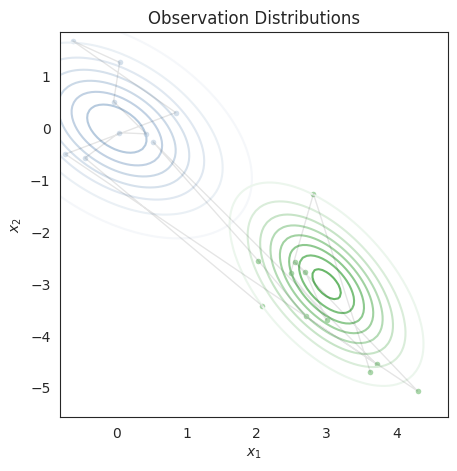

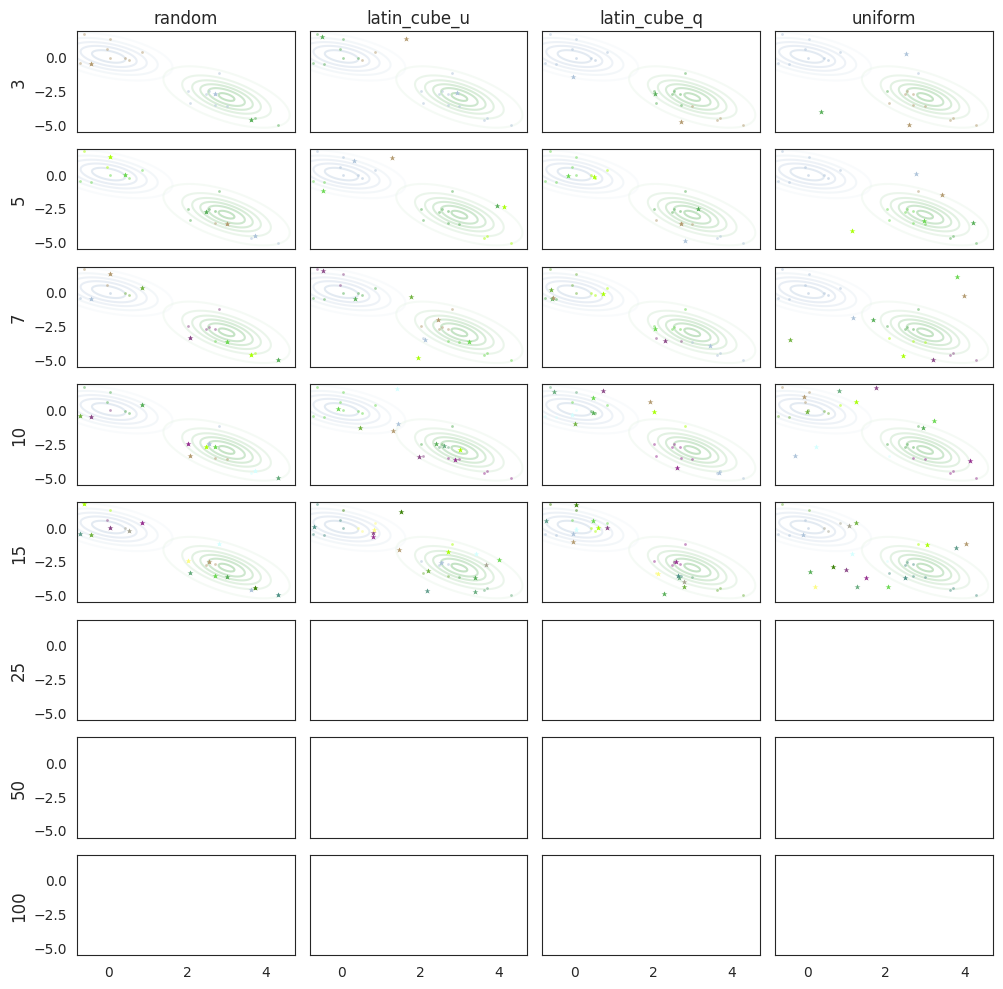

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3      0.60      -17.799542      8.083310e+16
20          None                3      1.00      -54.077037      1.420605e+01
5   latin_cube_u                3      0.90      -12.494001      1.628382e+19
15       uniform                3      0.90      -13.933288      3.860842e+18
10  latin_cube_q                3      0.65      -18.523026      3.920883e+16
1         random                5      0.90      -24.248245      1.279242e+14
21          None                5      1.00      -54.077037      1.420605e+01
6   latin_cube_u                5      0.65      -23.060436      4.195769e+14
16       uniform                5      0.55      -20.324024      6.474710e+15
11  latin_cube_q                5      0.60      -28.824406      1.316896e+12
22          None                7      1.00      -54.077037      1.420605e+01
17       uniform                7      0.90      -18.697363      3.293595e+16
12  latin_cube_q                7      0.60      -33.673223      1.032136e+10
7   latin_cube_u                7      0.50      -28.269755      2.293154e+12
2         random                7      0.90      -29.793548      4.996413e+11
13  latin_cube_q               10      0.90      -29.360866      7.701404e+11
8   latin_cube_u               10      0.55      -25.515272      3.603215e+13
18       uniform               10      0.90      -24.316958      1.194294e+14
3         random               10      0.90      -36.147299      8.694795e+08
23          None               10      1.00      -54.077037      1.420605e+01
14  latin_cube_q               15      0.65      -39.227169      3.996584e+07
9   latin_cube_u               15      0.90      -31.000382      1.494642e+11
19       uniform               15      0.90      -23.921797      1.773076e+14
4         random               15      0.90      -45.082951      1.144340e+05
24          None               15      1.00      -54.077037      1.420605e+01

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &      0.60 &      -17.799542 &      8.083310e+16 \\
20 &          None &                3 &      1.00 &      -54.077037 &      1.420605e+01 \\
5  &  latin\_cube\_u &                3 &      0.90 &      -12.494001 &      1.628382e+19 \\
15 &       uniform &                3 &      0.90 &      -13.933288 &      3.860842e+18 \\
10 &  latin\_cube\_q &                3 &      0.65 &      -18.523026 &      3.920883e+16 \\
1  &        random &                5 &      0.90 &      -24.248245 &      1.279242e+14 \\
21 &          None &                5 &      1.00 &      -54.077037 &      1.420605e+01 \\
6  &  latin\_cube\_u &                5 &      0.65 &      -23.060436 &      4.195769e+14 \\
16 &       uniform &                5 &      0.55 &      -20.324024 &      6.474710e+15 \\
11 &  latin\_cube\_q &                5 

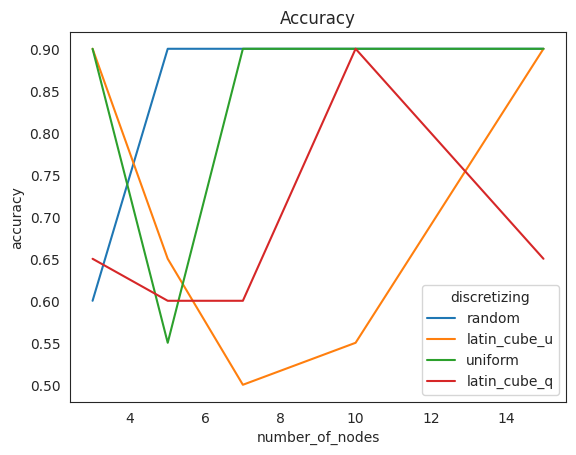

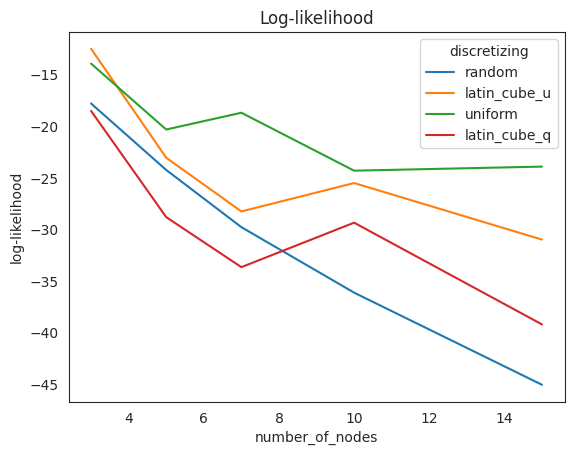

Fitting a model with 26 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 35 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 50 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 26 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 35 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 50 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 23 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 35 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a model with 50 free scalar parameters with only 20 data points will result in a degenerate solution.
Fitting a 

Recognized 1 instead of 3 states!


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

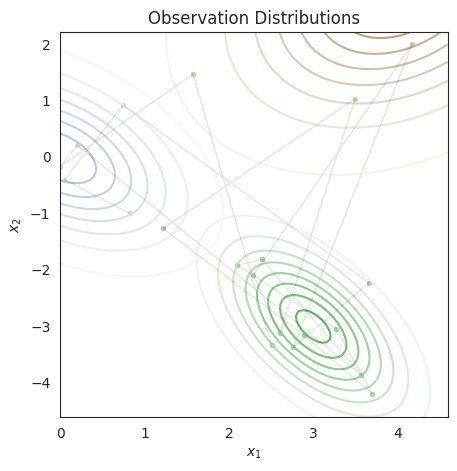

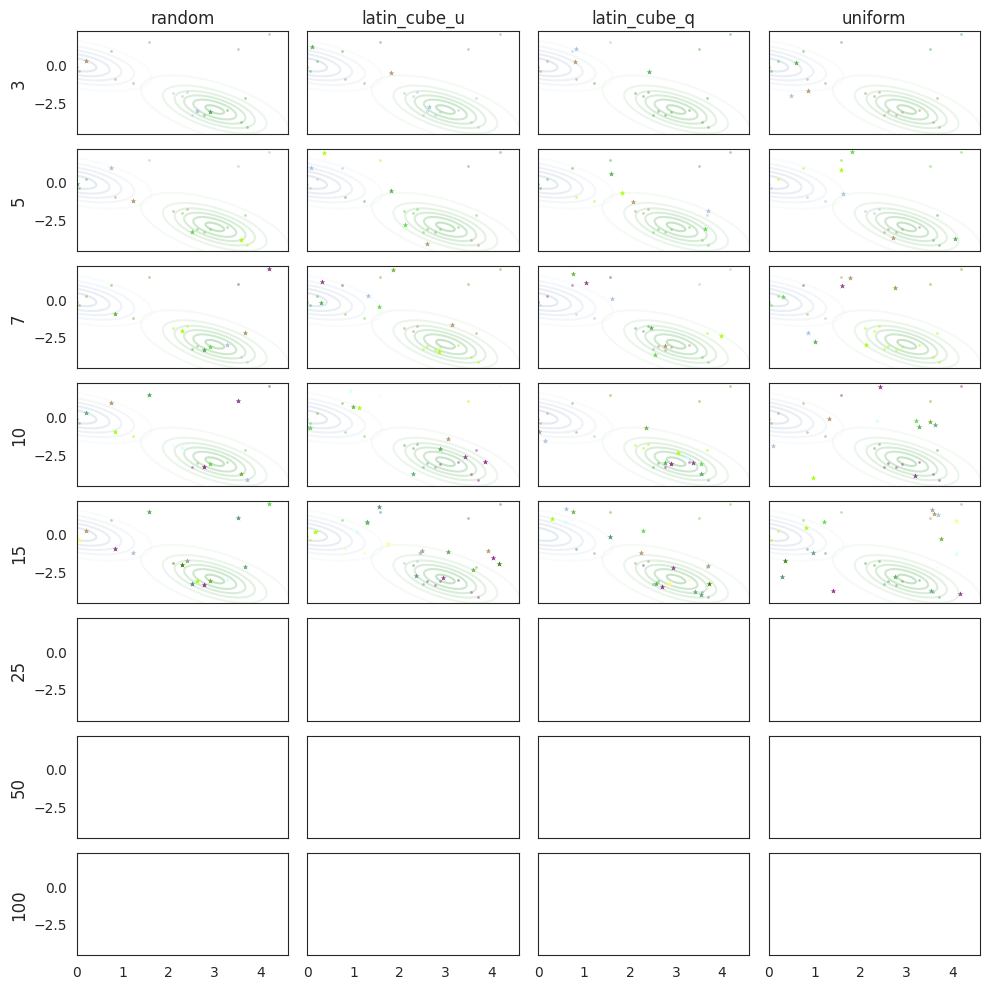

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3     -1.00      -21.318041      1.413020e+18
20          None                3      0.30      -58.613771      8.970534e+01
5   latin_cube_u                3      0.55      -16.712338      1.413773e+20
15       uniform                3      0.50      -12.445624      1.007836e+22
10  latin_cube_q                3      0.85       -6.298051      4.712454e+24
1         random                5      0.55      -22.396156      4.807605e+17
21          None                5      0.70      -58.864933      6.978147e+01
6   latin_cube_u                5      0.75      -24.255382      7.489917e+16
16       uniform                5      0.15      -24.523332      5.729384e+16
11  latin_cube_q                5      0.65      -23.555936      1.507450e+17
22          None                7      0.70      -52.751678      3.152776e+04
17       uniform                7      0.70      -20.171292      4.448103e+18
12  latin_cube_q                7      0.75      -30.174809      2.012346e+14
7   latin_cube_u                7      0.65      -26.922399      5.202433e+15
2         random                7      0.15      -29.975228      2.456856e+14
13  latin_cube_q               10      0.55      -28.866958      7.442098e+14
8   latin_cube_u               10      0.35      -31.852868      3.757778e+13
18       uniform               10      0.65      -27.349530      3.393952e+15
3         random               10      0.25      -32.023251      3.169089e+13
23          None               10      0.60      -57.916892      1.800816e+02
14  latin_cube_q               15      0.50      -33.959858      4.569586e+12
9   latin_cube_u               15      0.60      -30.245811      1.874421e+14
19       uniform               15      0.40      -29.731891      3.133715e+14
4         random               15      0.30      -39.310372      2.168594e+10
24          None               15      0.90      -53.068534      2.296593e+04

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &     -1.00 &      -21.318041 &      1.413020e+18 \\
20 &          None &                3 &      0.30 &      -58.613771 &      8.970534e+01 \\
5  &  latin\_cube\_u &                3 &      0.55 &      -16.712338 &      1.413773e+20 \\
15 &       uniform &                3 &      0.50 &      -12.445624 &      1.007836e+22 \\
10 &  latin\_cube\_q &                3 &      0.85 &       -6.298051 &      4.712454e+24 \\
1  &        random &                5 &      0.55 &      -22.396156 &      4.807605e+17 \\
21 &          None &                5 &      0.70 &      -58.864933 &      6.978147e+01 \\
6  &  latin\_cube\_u &                5 &      0.75 &      -24.255382 &      7.489917e+16 \\
16 &       uniform &                5 &      0.15 &      -24.523332 &      5.729384e+16 \\
11 &  latin\_cube\_q &                5 

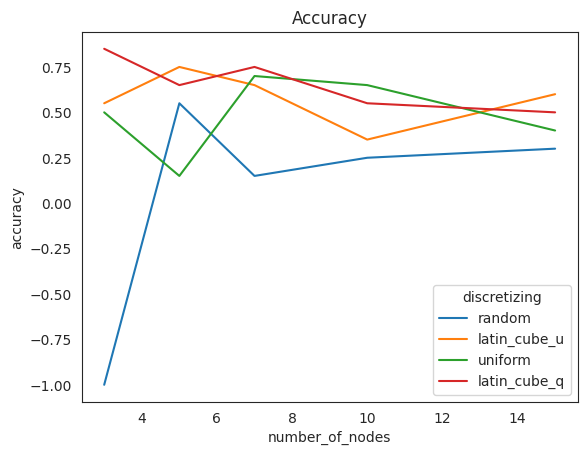

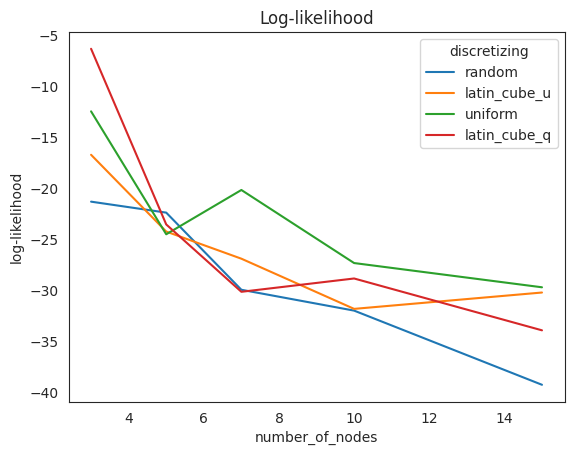

Fitting a model with 51 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 101 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 97 free scalar parameters with only 50 data points will result in a degenerate solution.


sample_size = 50


Fitting a model with 51 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 101 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 99 free scalar parameters with only 50 data points will result in a degenerate solution.
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recognized 1 instead of 2 states!


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

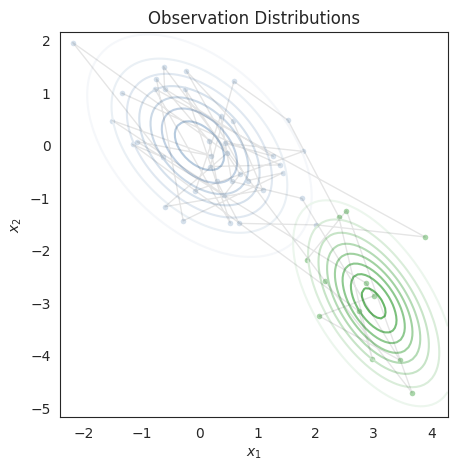

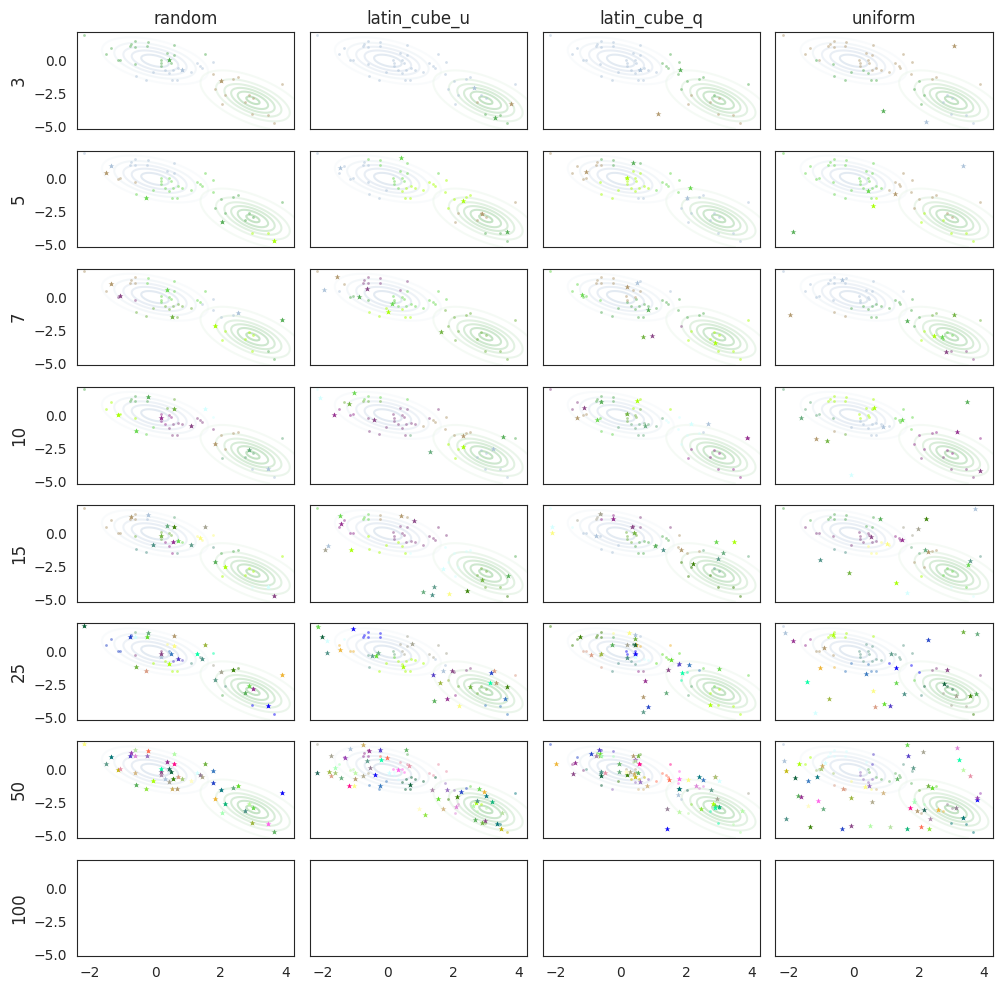

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3      0.96      -43.065071      2.863734e+45
14  latin_cube_q                3      0.94      -38.422619      2.972515e+47
21       uniform                3      0.62      -43.734166      1.466723e+45
7   latin_cube_u                3      0.78      -16.165127      1.378573e+57
28          None                3      0.98     -148.209396      6.213444e-01
22       uniform                5     -1.00      -47.376320      3.842209e+43
15  latin_cube_q                5      0.92      -64.804632      1.036481e+36
8   latin_cube_u                5      0.98      -69.495502      9.513541e+33
1         random                5      0.50      -67.705601      5.697529e+34
29          None                5      0.98     -148.209380      6.213542e-01
30          None                7      0.98     -148.209383      6.213524e-01
9   latin_cube_u                7      0.50      -75.845488      1.661798e+31
23       uniform                7      0.58      -71.202538      1.725783e+33
2         random                7      0.66      -88.517243      5.215608e+25
16  latin_cube_q                7      0.84      -69.994853      5.774000e+33
24       uniform               10      0.98      -82.761885      1.647500e+28
31          None               10      0.98     -148.209411      6.213350e-01
17  latin_cube_q               10      0.92      -99.217406      1.175664e+21
3         random               10      0.58     -107.761580      2.288735e+17
10  latin_cube_u               10      0.92      -85.010612      1.738664e+27
18  latin_cube_q               15      0.54     -109.339265      4.725151e+16
32          None               15      0.98     -148.209376      6.213567e-01
4         random               15      0.96     -114.548049      2.583864e+14
11  latin_cube_u               15      0.84      -89.469352      2.012841e+25
25       uniform               15      0.86     -101.824457      8.670726e+19
5         random               25      0.50     -136.284052      9.385196e+04
26       uniform               25      0.56     -103.710749      1.314769e+19
12  latin_cube_u               25      0.72     -111.012472      8.866479e+15
19  latin_cube_q               25      0.54     -130.834266      2.184014e+07
33          None               25      0.98     -148.209391      6.213478e-01
27       uniform               50      0.76     -121.055775      3.854786e+11
6         random               50      0.58     -174.041446      3.755049e-12
13  latin_cube_u               50      0.50     -132.497099      4.140913e+06
20  latin_cube_q               50      0.88     -150.771129      4.794972e-02
34          None               50      0.98     -148.209384      6.213518e-01

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &      0.96 &      -43.065071 &      2.863734e+45 \\
14 &  latin\_cube\_q &                3 &      0.94 &      -38.422619 &      2.972515e+47 \\
21 &       uniform &                3 &      0.62 &      -43.734166 &      1.466723e+45 \\
7  &  latin\_cube\_u &                3 &      0.78 &      -16.165127 &      1.378573e+57 \\
28 &          None &                3 &      0.98 &     -148.209396 &      6.213444e-01 \\
22 &       uniform &                5 &     -1.00 &      -47.376320 &      3.842209e+43 \\
15 &  latin\_cube\_q &                5 &      0.92 &      -64.804632 &      1.036481e+36 \\
8  &  latin\_cube\_u &                5 &      0.98 &      -69.495502 &      9.513541e+33 \\
1  &        random &                5 &      0.50 &      -67.705601 &      5.697529e+34 \\
29 &          None &                5 

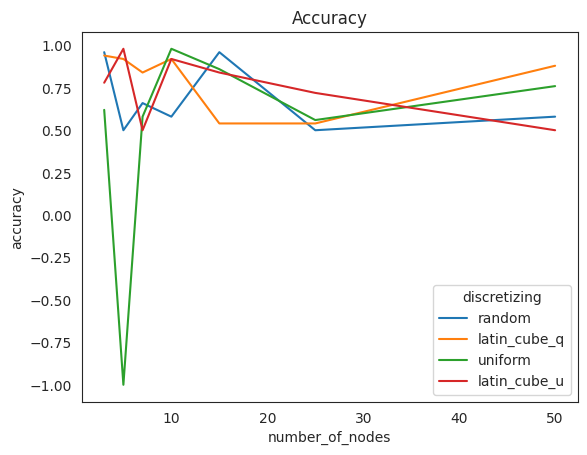

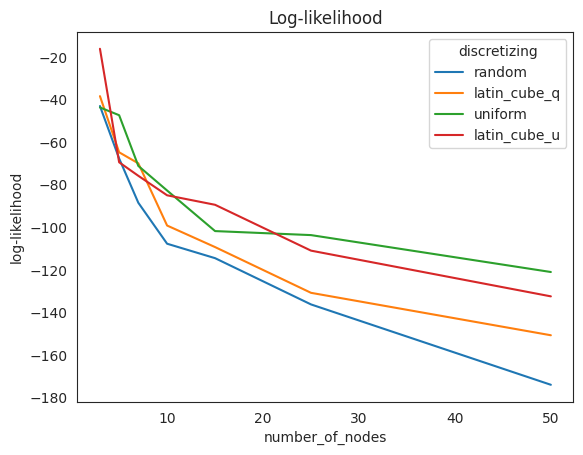

Fitting a model with 80 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 155 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 80 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 146 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 80 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 155 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 74 free scalar parameters with only 50 data points will result in a degenerate solution.
Fitting a model with 152 free scalar parameters with only 50 data points will result in a degenerate solution.
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value o

Recognized 2 instead of 3 states!


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

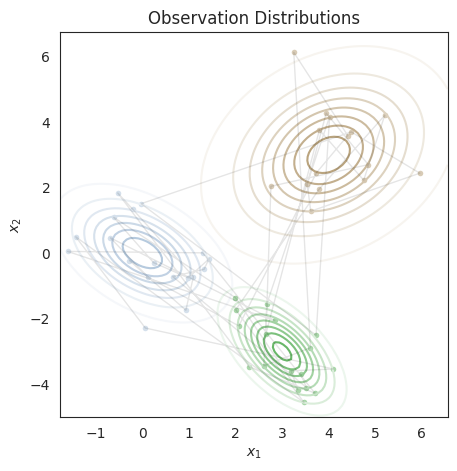

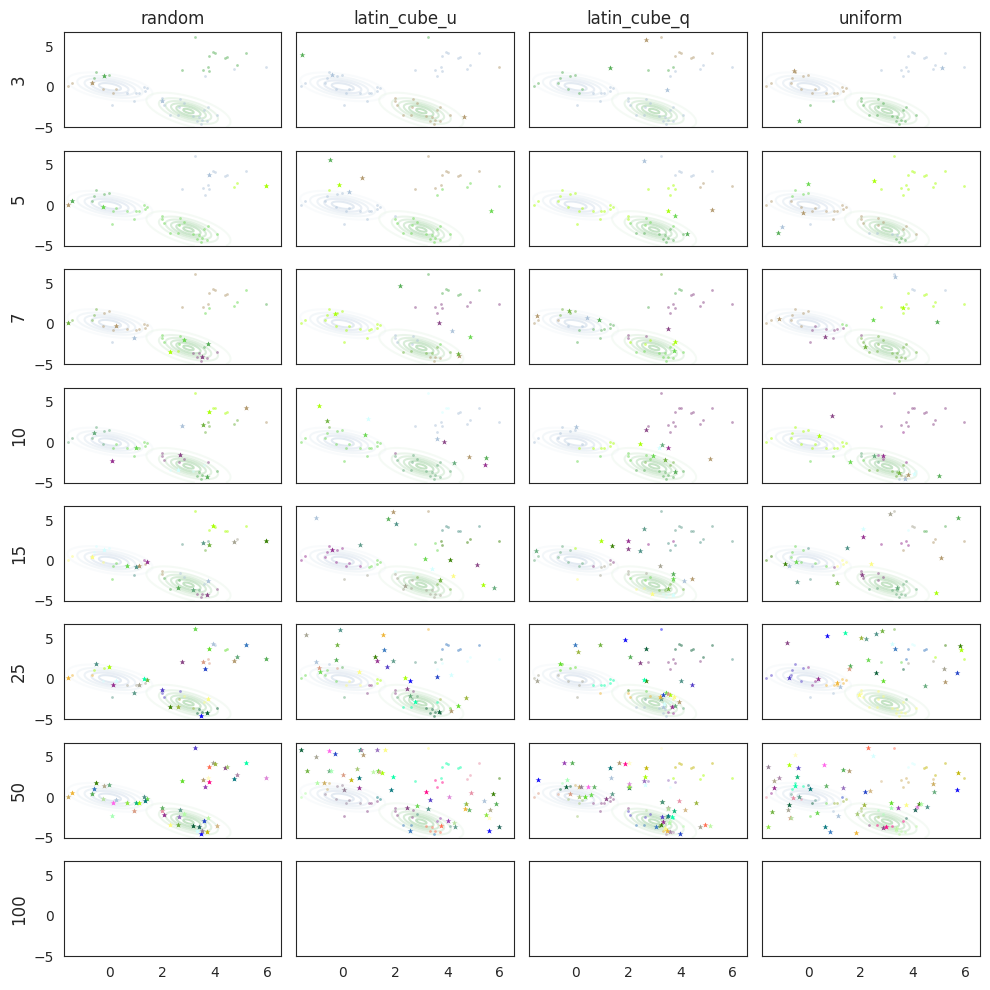

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3      0.34      -44.709748      1.982924e+56
14  latin_cube_q                3      0.54      -43.695599      5.466951e+56
21       uniform                3      0.84      -40.341293      1.564956e+58
7   latin_cube_u                3      0.68      -33.057795      2.278689e+61
28          None                3      0.98     -171.025298      2.748906e+01
22       uniform                5     -1.00      -63.451926      1.437744e+48
15  latin_cube_q                5      0.78      -56.282642      1.867506e+51
8   latin_cube_u                5      0.58      -46.100324      4.936130e+55
1         random                5      0.60      -45.247299      1.158379e+56
29          None                5      0.02     -171.025303      2.748891e+01
30          None                7      0.00     -171.025316      2.748856e+01
9   latin_cube_u                7      0.62      -66.932729      4.425763e+46
23       uniform                7      0.14      -63.728834      1.089988e+48
2         random                7      0.48      -73.544052      5.952874e+43
16  latin_cube_q                7      0.40      -82.909050      5.099879e+39
24       uniform               10      0.60      -77.386543      1.276304e+42
31          None               10      0.98     -171.025284      2.748944e+01
17  latin_cube_q               10      0.72      -63.124447      1.994821e+48
3         random               10      0.24      -87.656168      4.424997e+37
10  latin_cube_u               10      0.66      -56.833444      1.076594e+51
18  latin_cube_q               15      0.74      -89.826495      5.050703e+36
32          None               15      0.02     -171.025437      2.748523e+01
4         random               15      0.56     -104.287417      2.648823e+30
11  latin_cube_u               15      0.52      -82.836092      5.485864e+39
25       uniform               15      0.68     -100.865630      8.111780e+31
5         random               25      0.26     -128.809525      5.932491e+19
26       uniform               25      0.14      -90.426496      2.771883e+36
12  latin_cube_u               25      0.40     -108.514498      3.865942e+28
19  latin_cube_q               25      0.28      -96.862755      4.441637e+33
33          None               25      0.98     -171.025408      2.748602e+01
27       uniform               50      0.38     -129.130863      4.302113e+19
6         random               50      0.36     -163.852540      3.583018e+04
13  latin_cube_u               50      0.70     -102.244439      2.043184e+31
20  latin_cube_q               50      0.48     -120.436896      2.566987e+23
34          None               50      0.00     -171.025327      2.748825e+01

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &      0.34 &      -44.709748 &      1.982924e+56 \\
14 &  latin\_cube\_q &                3 &      0.54 &      -43.695599 &      5.466951e+56 \\
21 &       uniform &                3 &      0.84 &      -40.341293 &      1.564956e+58 \\
7  &  latin\_cube\_u &                3 &      0.68 &      -33.057795 &      2.278689e+61 \\
28 &          None &                3 &      0.98 &     -171.025298 &      2.748906e+01 \\
22 &       uniform &                5 &     -1.00 &      -63.451926 &      1.437744e+48 \\
15 &  latin\_cube\_q &                5 &      0.78 &      -56.282642 &      1.867506e+51 \\
8  &  latin\_cube\_u &                5 &      0.58 &      -46.100324 &      4.936130e+55 \\
1  &        random &                5 &      0.60 &      -45.247299 &      1.158379e+56 \\
29 &          None &                5 

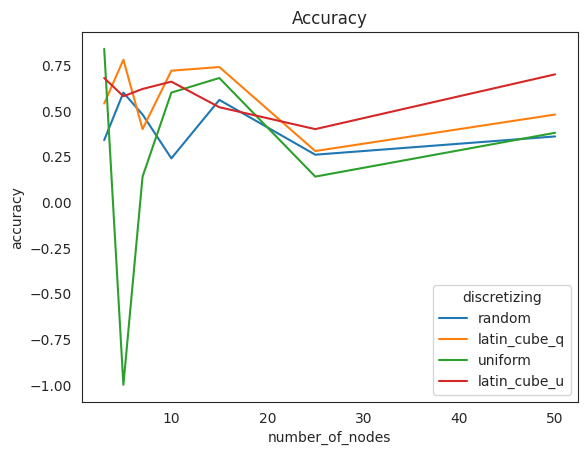

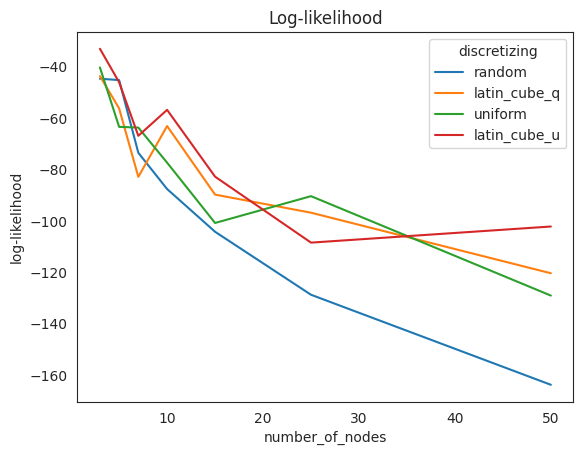

Fitting a model with 101 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 201 free scalar parameters with only 100 data points will result in a degenerate solution.


sample_size = 100
Recognized 1 instead of 2 states!
Recognized 1 instead of 2 states!


Fitting a model with 191 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 101 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 199 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 185 free scalar parameters with only 100 data points will result in a degenerate solution.
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recognized 1 instead of 2 states!
Recognized 1 instead of 2 states!


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

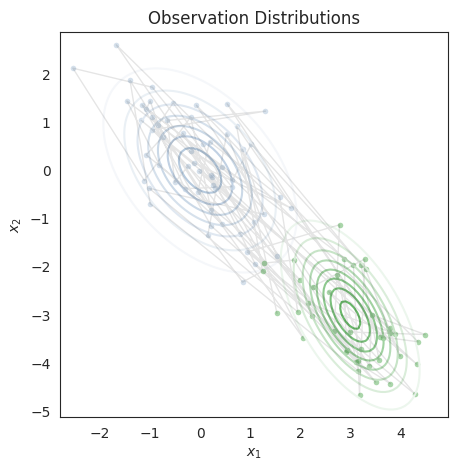

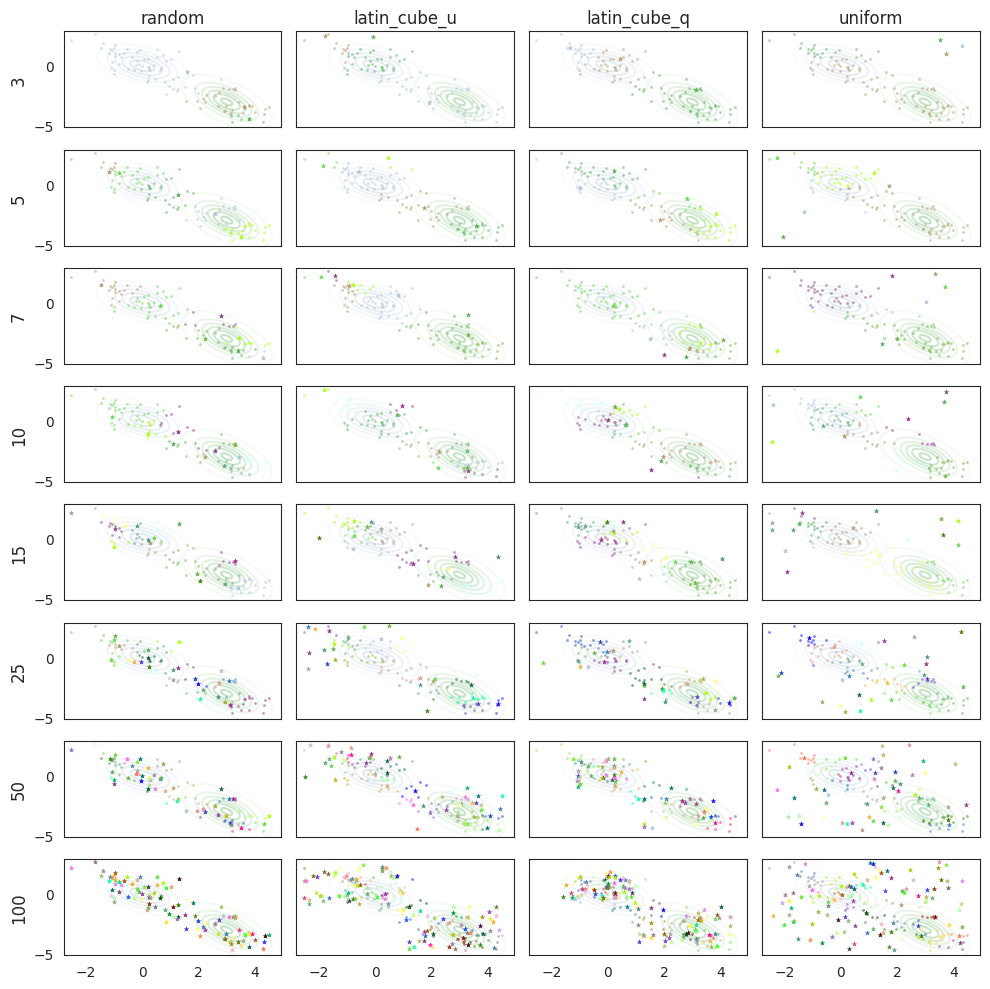

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3     -1.00      -83.842206      6.183897e+98
24       uniform                3     -1.00      -50.034046     2.978238e+113
32          None                3      0.96     -328.338920      4.052177e-08
8   latin_cube_u                3      0.57      -93.767105      3.026447e+94
16  latin_cube_q                3      0.57     -101.923693      8.681050e+90
33          None                5      0.96     -328.339848      4.048419e-08
17  latin_cube_q                5      0.86     -149.922809      1.238285e+70
9   latin_cube_u                5     -1.00     -128.137169      3.582648e+79
25       uniform                5     -1.00     -107.338213      3.864346e+88
1         random                5      0.96     -149.168526      2.632703e+70
34          None                7      0.96     -328.346897      4.019981e-08
2         random                7      0.53     -170.344387      1.674335e+61
10  latin_cube_u                7      0.83     -141.581027      5.195303e+73
26       uniform                7      0.57     -112.102580      3.295623e+86
18  latin_cube_q                7      0.86     -128.795174      1.855394e+79
27       uniform               10      0.50     -183.007479      5.300678e+55
35          None               10      0.98     -328.413837      3.759693e-08
19  latin_cube_q               10      0.83     -180.932723      4.220718e+56
3         random               10      0.78     -188.303752      2.655762e+53
11  latin_cube_u               10      0.84     -181.665201      2.028967e+56
28       uniform               15      0.55     -163.150957      2.227968e+64
20  latin_cube_q               15      0.53     -223.852209      9.675878e+37
36          None               15      0.96     -328.339599      4.049425e-08
12  latin_cube_u               15      0.51     -212.631548      7.223734e+42
4         random               15      0.54     -238.749126      3.281267e+31
37          None               25      0.96     -328.339221      4.050956e-08
21  latin_cube_q               25      0.57     -258.719065      6.969589e+22
13  latin_cube_u               25      0.81     -244.285910      1.292549e+29
5         random               25      0.50     -274.530444      9.471367e+15
29       uniform               25      0.54     -221.037613      1.614559e+39
6         random               50      0.53     -345.001679      2.350413e-15
14  latin_cube_u               50      0.51     -309.285140      7.632027e+00
30       uniform               50      0.55     -270.179103      7.348114e+17
22  latin_cube_q               50      0.55     -320.597792      9.324332e-05
38          None               50      0.98     -328.412939      3.763070e-08
15  latin_cube_u              100      0.63     -353.408114      5.251405e-19
7         random              100      0.57     -454.916866      4.321006e-63
23  latin_cube_q              100      0.51     -351.518581      3.474476e-18
31       uniform              100      0.74     -305.815175      2.452600e+02
39          None              100      0.96     -328.338575      4.053576e-08

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &     -1.00 &      -83.842206 &      6.183897e+98 \\
24 &       uniform &                3 &     -1.00 &      -50.034046 &     2.978238e+113 \\
32 &          None &                3 &      0.96 &     -328.338920 &      4.052177e-08 \\
8  &  latin\_cube\_u &                3 &      0.57 &      -93.767105 &      3.026447e+94 \\
16 &  latin\_cube\_q &                3 &      0.57 &     -101.923693 &      8.681050e+90 \\
33 &          None &                5 &      0.96 &     -328.339848 &      4.048419e-08 \\
17 &  latin\_cube\_q &                5 &      0.86 &     -149.922809 &      1.238285e+70 \\
9  &  latin\_cube\_u &                5 &     -1.00 &     -128.137169 &      3.582648e+79 \\
25 &       uniform &                5 &     -1.00 &     -107.338213 &      3.864346e+88 \\
1  &        random &                5 

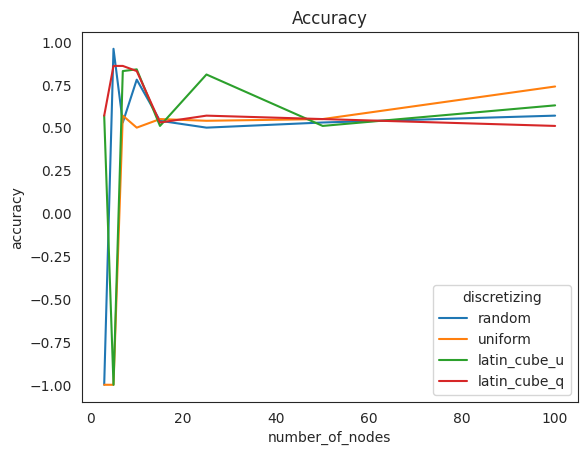

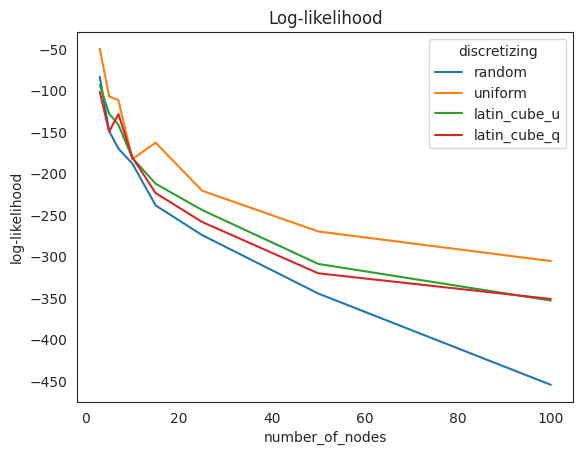

Fitting a model with 155 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 305 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 131 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 296 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 152 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 296 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 155 free scalar parameters with only 100 data points will result in a degenerate solution.
Fitting a model with 305 free scalar parameters with only 100 data points will result in a degenerate solution.
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The def

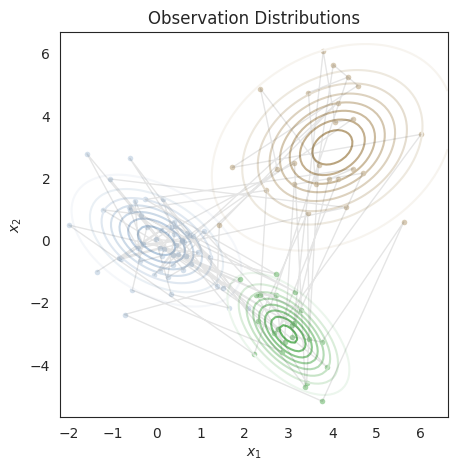

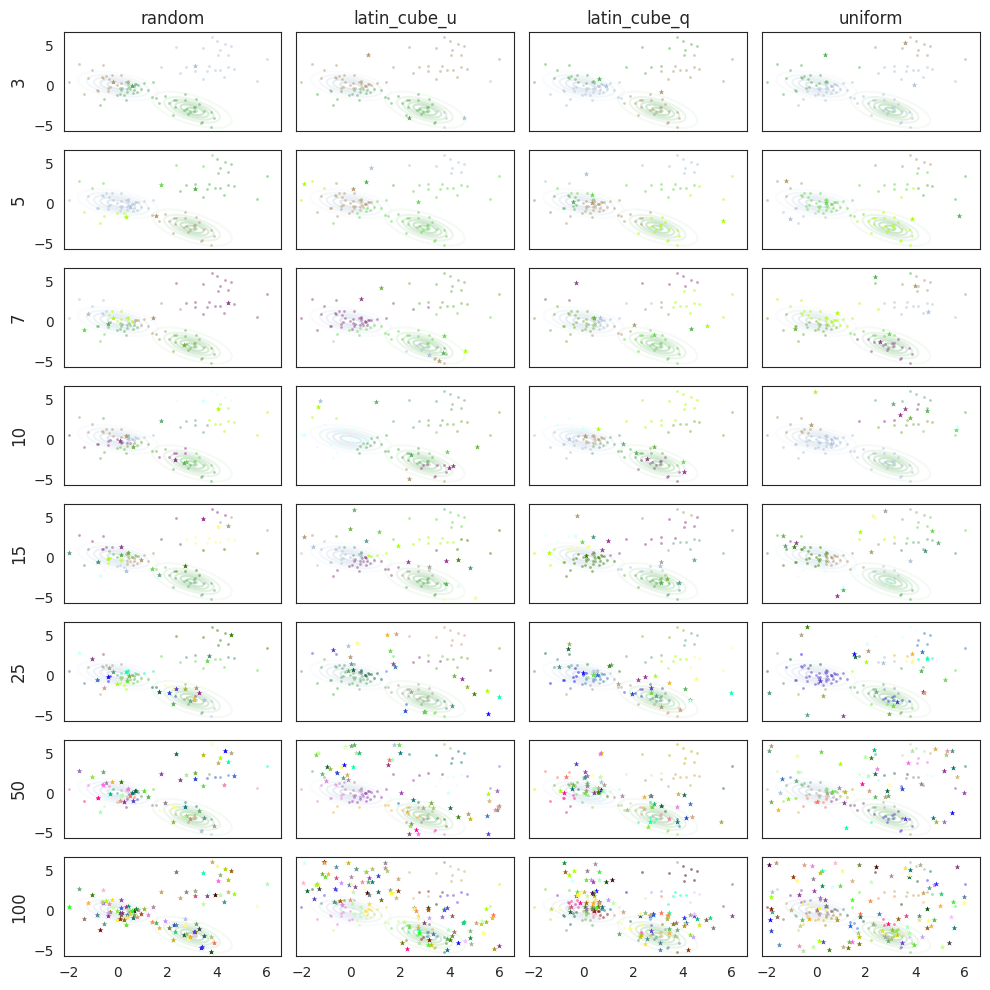

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3      0.79      -91.632695     2.458106e+115
24       uniform                3      0.65      -76.178359     1.265708e+122
32          None                3      0.97     -354.109901      2.501489e+01
8   latin_cube_u                3      0.18      -79.068765     7.031471e+120
16  latin_cube_q                3      0.26      -98.069630     3.936182e+112
33          None                5      0.01     -354.109688      2.502022e+01
17  latin_cube_q                5      0.50     -142.375407      2.255905e+93
9   latin_cube_u                5      0.20      -98.944679     1.640765e+112
25       uniform                5      0.47     -122.030859     1.544705e+102
1         random                5      0.73     -123.294552     4.365467e+101
34          None                7      0.97     -354.109781      2.501788e+01
2         random                7      0.43     -173.820935      4.973949e+79
10  latin_cube_u                7      0.10     -122.523159     9.441532e+101
26       uniform                7      0.08     -155.434348      4.807227e+87
18  latin_cube_q                7      0.61     -154.381015      1.378324e+88
27       uniform               10      0.56     -107.937743     2.038958e+108
35          None               10      0.01     -354.109031      2.503664e+01
19  latin_cube_q               10      0.37     -201.133060      6.842206e+67
3         random               10      0.10     -204.069871      3.628737e+66
11  latin_cube_u               10      0.85     -146.643015      3.161711e+91
28       uniform               15      0.64     -194.260106      6.608188e+70
20  latin_cube_q               15      0.42     -201.549644      4.511037e+67
36          None               15      0.01     -354.108933      2.503910e+01
12  latin_cube_u               15      0.23     -195.211019      2.553324e+70
4         random               15      0.38     -233.196857      8.129546e+53
37          None               25      0.97     -354.110132      2.500911e+01
21  latin_cube_q               25      0.38     -235.517151      7.986846e+52
13  latin_cube_u               25      0.79     -195.975570      1.188682e+70
5         random               25      0.48     -269.227217      1.829279e+38
29       uniform               25      0.40     -202.425922      1.878078e+67
6         random               50      0.41     -321.190721      4.952410e+15
14  latin_cube_u               50      0.57     -225.189937      2.440211e+57
30       uniform               50      0.68     -259.225041      4.038029e+42
22  latin_cube_q               50      0.44     -283.990784      7.088333e+31
38          None               50      0.02     -372.065796      3.981551e-07
15  latin_cube_u              100      0.28     -281.580855      7.891559e+32
7         random              100      0.24     -392.094825      7.971786e-16
23  latin_cube_q              100      0.49     -304.053759      1.371844e+23
31       uniform              100      0.50     -308.309270      1.946077e+21
39          None              100      0.01     -354.109914      2.501457e+01

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &      0.79 &      -91.632695 &     2.458106e+115 \\
24 &       uniform &                3 &      0.65 &      -76.178359 &     1.265708e+122 \\
32 &          None &                3 &      0.97 &     -354.109901 &      2.501489e+01 \\
8  &  latin\_cube\_u &                3 &      0.18 &      -79.068765 &     7.031471e+120 \\
16 &  latin\_cube\_q &                3 &      0.26 &      -98.069630 &     3.936182e+112 \\
33 &          None &                5 &      0.01 &     -354.109688 &      2.502022e+01 \\
17 &  latin\_cube\_q &                5 &      0.50 &     -142.375407 &      2.255905e+93 \\
9  &  latin\_cube\_u &                5 &      0.20 &      -98.944679 &     1.640765e+112 \\
25 &       uniform &                5 &      0.47 &     -122.030859 &     1.544705e+102 \\
1  &        random &                5 

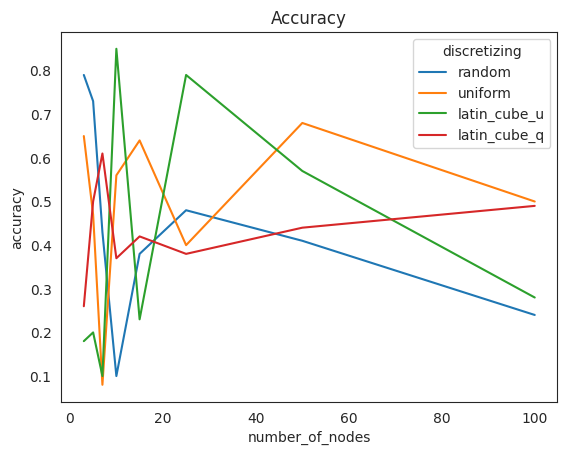

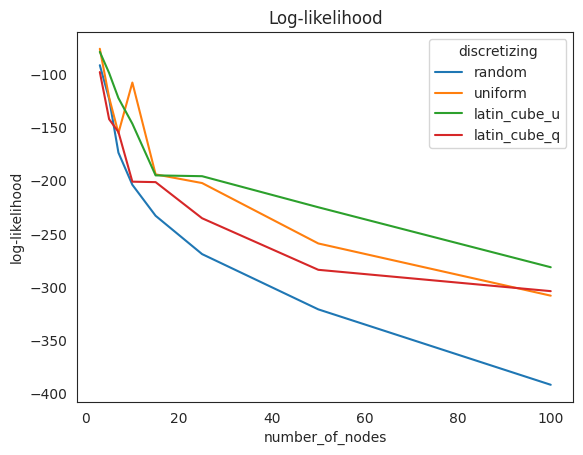

sample_size = 1000
Recognized 1 instead of 2 states!
Recognized 1 instead of 2 states!


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

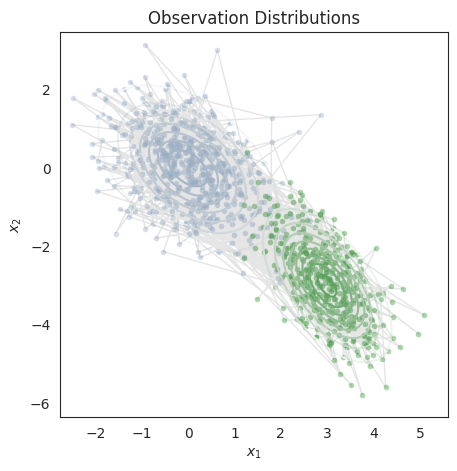

/tmp/ipykernel_54422/2508230348.py:60: RuntimeWarning: overflow encountered in exp
  'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)


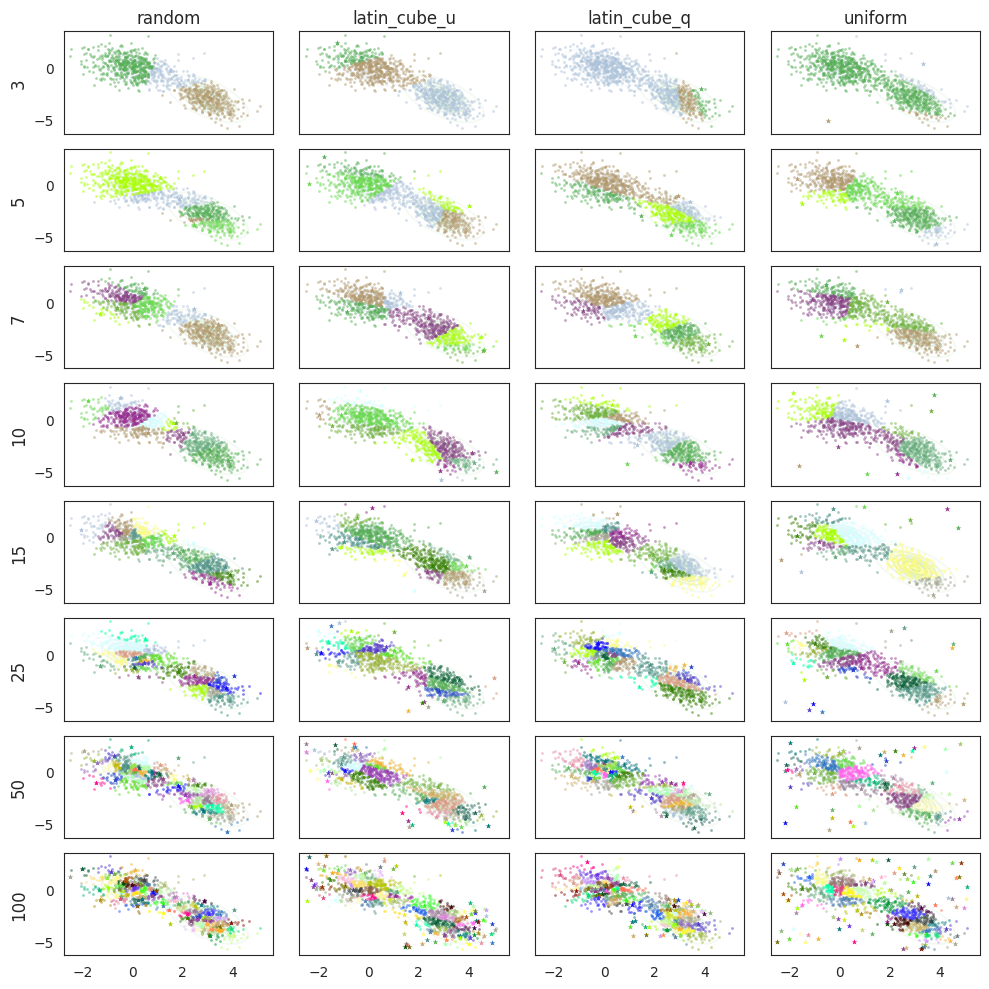

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3     0.956     -962.252612               inf
24       uniform                3     0.629     -321.227909               inf
32          None                3     0.974    -3099.383847      7.223287e-54
8   latin_cube_u                3    -1.000    -1011.464923               inf
16  latin_cube_q                3    -1.000     -584.768157               inf
33          None                5     0.974    -3099.383870      7.223122e-54
17  latin_cube_q                5     0.902    -1349.483449               inf
9   latin_cube_u                5     0.851    -1384.692713               inf
25       uniform                5     0.516    -1401.124204               inf
1         random                5     0.906    -1281.301558               inf
34          None                7     0.974    -3099.384075      7.221636e-54
2         random                7     0.504    -1708.690169               inf
10  latin_cube_u                7     0.928    -1618.375773               inf
26       uniform                7     0.501    -1474.265017               inf
18  latin_cube_q                7     0.501    -1771.781968               inf
27       uniform               10     0.601    -1584.872611               inf
35          None               10     0.974    -3099.383675      7.224525e-54
19  latin_cube_q               10     0.952    -2041.212472               inf
3         random               10     0.554    -1978.065757               inf
11  latin_cube_u               10     0.511    -1714.662907               inf
28       uniform               15     0.962    -1849.087166               inf
20  latin_cube_q               15     0.937    -2414.534446     1.927749e+244
36          None               15     0.974    -3099.383862      7.223174e-54
12  latin_cube_u               15     0.506    -2040.981182               inf
4         random               15     0.955    -2498.246308     8.500624e+207
37          None               25     0.974    -3099.383817      7.223503e-54
21  latin_cube_q               25     0.910    -2796.105824      3.721401e+78
13  latin_cube_u               25     0.932    -2387.708830     8.615244e+255
5         random               25     0.510    -2899.335356      5.478864e+33
29       uniform               25     0.505    -2433.930774     7.266618e+235
6         random               50     0.512    -3701.055493     3.597982e-315
14  latin_cube_u               50     0.921    -2853.981712      2.726013e+53
30       uniform               50     0.961    -2696.102063     1.004126e+122
22  latin_cube_q               50     0.536    -3534.096825     1.162217e-242
38          None               50     0.974    -3099.383847      7.223284e-54
15  latin_cube_u              100     0.894    -3647.038117     1.036352e-291
7         random              100     0.504    -4387.627320      0.000000e+00
23  latin_cube_q              100     0.509    -4082.638256      0.000000e+00
31       uniform              100     0.915    -3251.591863     5.696831e-120
39          None              100     0.974    -3099.383954      7.222511e-54

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &     0.956 &     -962.252612 &               inf \\
24 &       uniform &                3 &     0.629 &     -321.227909 &               inf \\
32 &          None &                3 &     0.974 &    -3099.383847 &      7.223287e-54 \\
8  &  latin\_cube\_u &                3 &    -1.000 &    -1011.464923 &               inf \\
16 &  latin\_cube\_q &                3 &    -1.000 &     -584.768157 &               inf \\
33 &          None &                5 &     0.974 &    -3099.383870 &      7.223122e-54 \\
17 &  latin\_cube\_q &                5 &     0.902 &    -1349.483449 &               inf \\
9  &  latin\_cube\_u &                5 &     0.851 &    -1384.692713 &               inf \\
25 &       uniform &                5 &     0.516 &    -1401.124204 &               inf \\
1  &        random &                5 

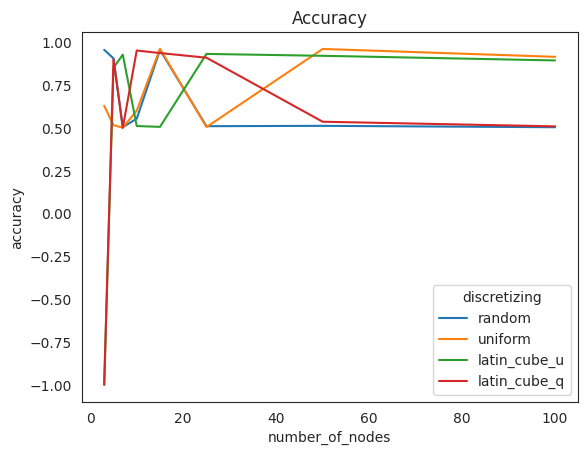

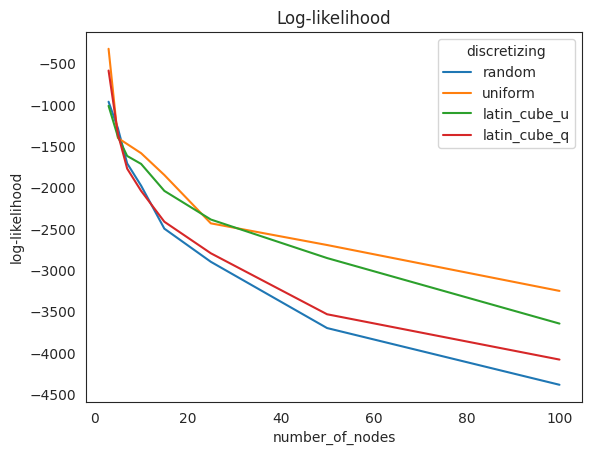

Recognized 2 instead of 3 states!
Recognized 1 instead of 3 states!


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

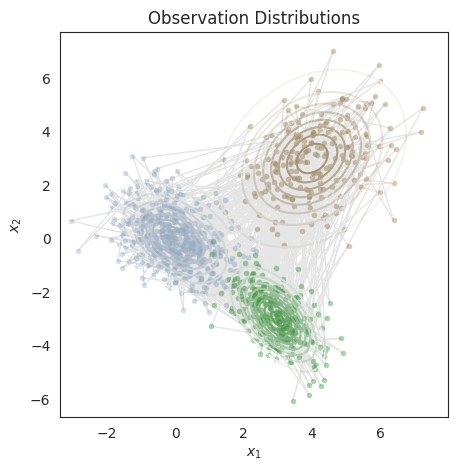

/tmp/ipykernel_54422/2508230348.py:60: RuntimeWarning: overflow encountered in exp
  'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)


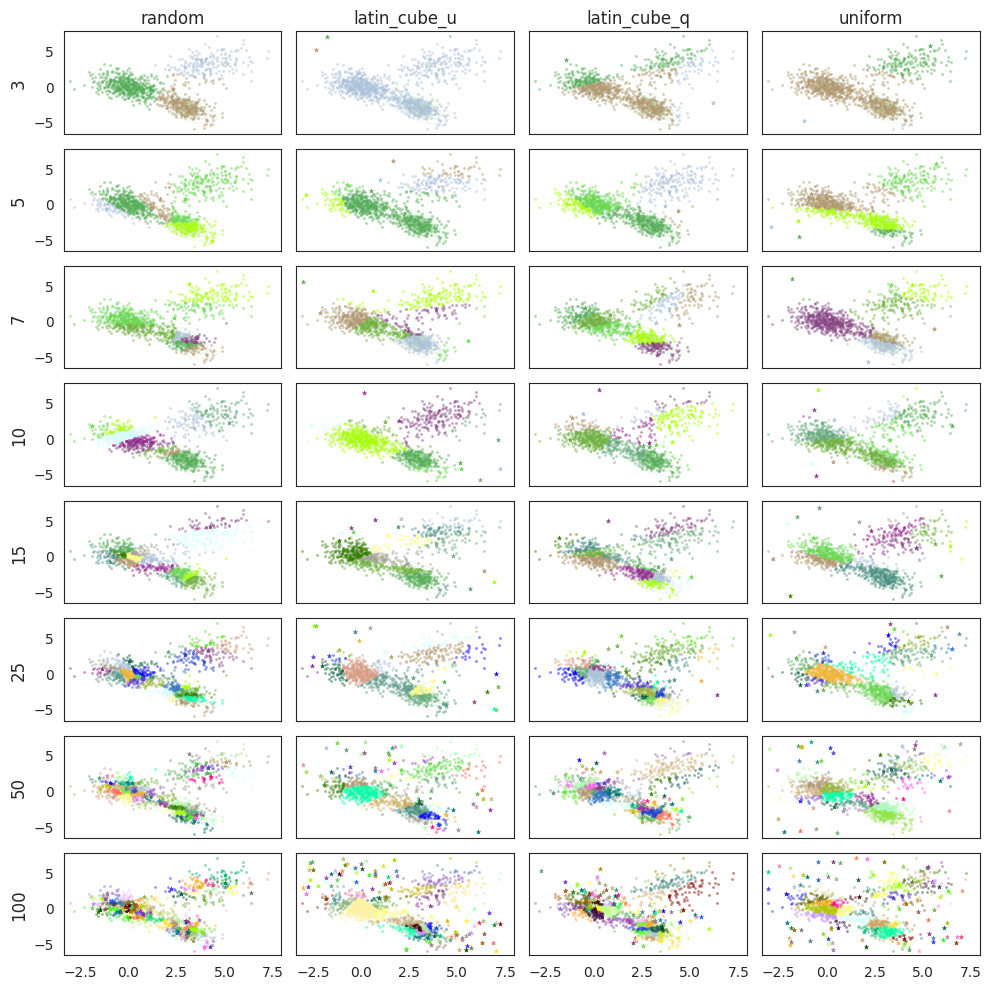

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3     0.710     -956.667759               inf
24       uniform                3     0.512     -469.801312               inf
32          None                3     0.979    -3609.715042      7.768523e-43
8   latin_cube_u                3    -1.000       -7.912357               inf
16  latin_cube_q                3    -1.000     -802.398491               inf
33          None                5     0.979    -3609.714824      7.770213e-43
17  latin_cube_q                5     0.470    -1290.415821               inf
9   latin_cube_u                5     0.372     -853.260509               inf
25       uniform                5     0.411    -1207.974354               inf
1         random                5     0.607    -1377.520133               inf
34          None                7     0.979    -3609.714683      7.771307e-43
2         random                7     0.209    -1581.876708               inf
10  latin_cube_u                7     0.149    -1565.741668               inf
26       uniform                7     0.707    -1327.152042               inf
18  latin_cube_q                7     0.160    -1805.401631               inf
27       uniform               10     0.526    -1476.118838               inf
35          None               10     0.979    -3609.714157      7.775400e-43
19  latin_cube_q               10     0.485    -1712.940540               inf
3         random               10     0.640    -2025.263714               inf
11  latin_cube_u               10     0.637    -1306.533377               inf
28       uniform               15     0.672    -1667.319908               inf
20  latin_cube_q               15     0.194    -2235.702066               inf
36          None               15     0.979    -3609.714188      7.775160e-43
12  latin_cube_u               15     0.149    -1910.151060               inf
4         random               15     0.603    -2542.242102               inf
37          None               25     0.979    -3609.714461      7.773034e-43
21  latin_cube_q               25     0.623    -2714.853469               inf
13  latin_cube_u               25     0.649    -1971.406066               inf
5         random               25     0.343    -3074.974881     1.333643e+190
29       uniform               25     0.500    -2151.454213               inf
6         random               50     0.250    -3665.499764      4.606183e-67
14  latin_cube_u               50     0.105    -2448.876150               inf
30       uniform               50     0.233    -2686.465555               inf
22  latin_cube_q               50     0.511    -3250.420404     8.511715e+113
38          None               50     0.979    -3609.714124      7.775655e-43
15  latin_cube_u              100     0.483    -2761.234077               inf
7         random              100     0.405    -4251.240512     1.902153e-321
23  latin_cube_q              100     0.455    -3565.216715      1.643298e-23
31       uniform              100     0.367    -3152.340535     3.353998e+156
39          None              100     0.979    -3609.715444      7.765402e-43

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &     0.710 &     -956.667759 &               inf \\
24 &       uniform &                3 &     0.512 &     -469.801312 &               inf \\
32 &          None &                3 &     0.979 &    -3609.715042 &      7.768523e-43 \\
8  &  latin\_cube\_u &                3 &    -1.000 &       -7.912357 &               inf \\
16 &  latin\_cube\_q &                3 &    -1.000 &     -802.398491 &               inf \\
33 &          None &                5 &     0.979 &    -3609.714824 &      7.770213e-43 \\
17 &  latin\_cube\_q &                5 &     0.470 &    -1290.415821 &               inf \\
9  &  latin\_cube\_u &                5 &     0.372 &     -853.260509 &               inf \\
25 &       uniform &                5 &     0.411 &    -1207.974354 &               inf \\
1  &        random &                5 

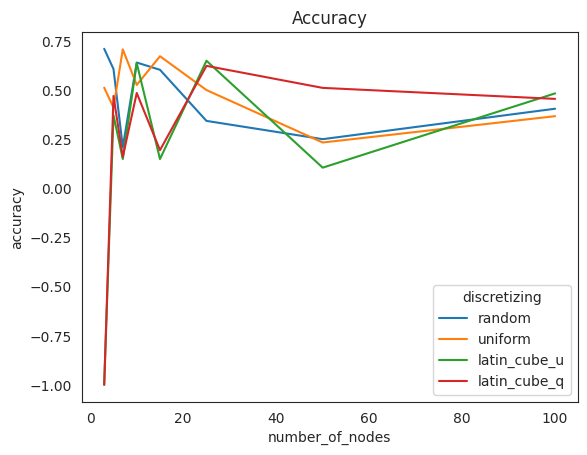

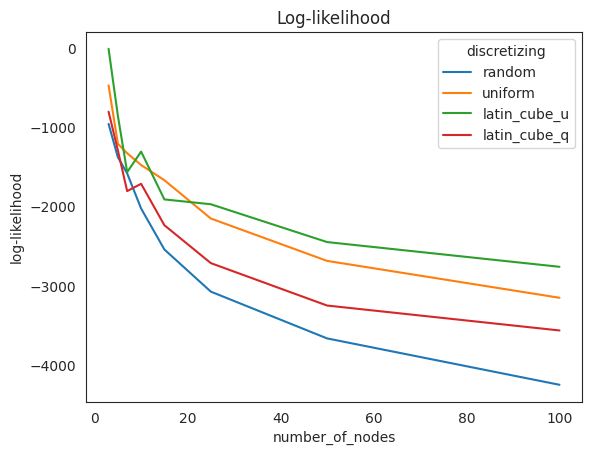

sample_size = 10000


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

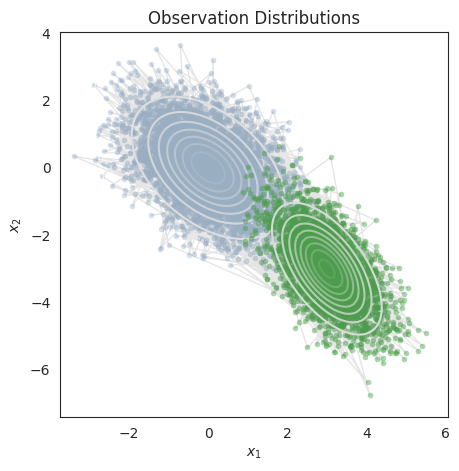

/tmp/ipykernel_54422/2508230348.py:60: RuntimeWarning: overflow encountered in exp
  'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)


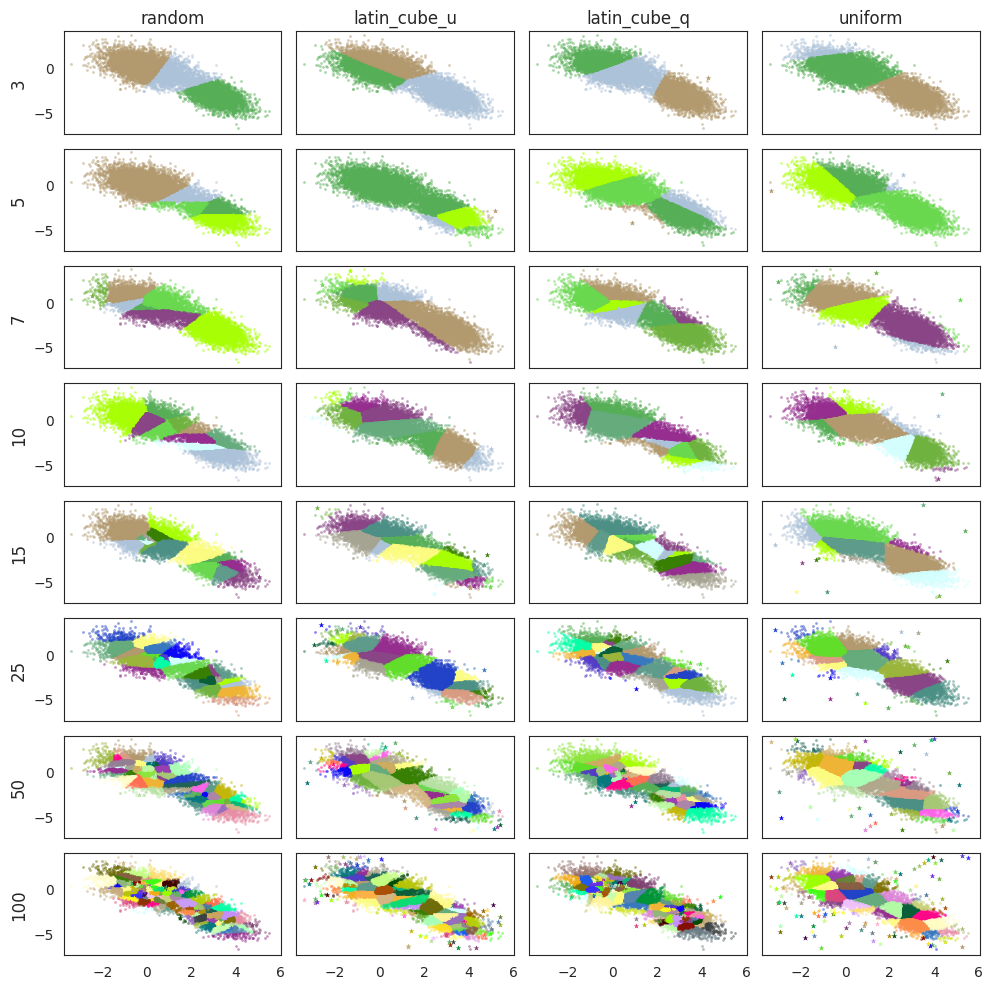

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3    0.5167   -10653.845848               inf
24       uniform                3    0.5376    -8420.761914               inf
32          None                3    0.9785   -31238.463701      0.000000e+00
8   latin_cube_u                3    0.9638   -10225.405687               inf
16  latin_cube_q                3    0.5955   -10802.429404               inf
33          None                5    0.9784   -31238.464025      0.000000e+00
17  latin_cube_q                5    0.9746   -12755.709066               inf
9   latin_cube_u                5    0.8037    -6236.228979               inf
25       uniform                5    0.9477   -10488.945330               inf
1         random                5    0.5054   -12923.918276               inf
34          None                7    0.9785   -31238.463733      0.000000e+00
2         random                7    0.5887   -16590.904729               inf
10  latin_cube_u                7    0.8647   -13697.927303               inf
26       uniform                7    0.9674   -11951.778522               inf
18  latin_cube_q                7    0.9683   -17549.851860               inf
27       uniform               10    0.5067   -15738.118260               inf
35          None               10    0.9785   -31238.463722      0.000000e+00
19  latin_cube_q               10    0.9631   -18777.664443               inf
3         random               10    0.9679   -20638.595393               inf
11  latin_cube_u               10    0.5024   -17284.636475               inf
28       uniform               15    0.9733   -14440.207391               inf
20  latin_cube_q               15    0.9096   -24503.466741               inf
36          None               15    0.9785   -31238.463767      0.000000e+00
12  latin_cube_u               15    0.9531   -20772.747994               inf
4         random               15    0.5070   -24750.073196               inf
37          None               25    0.9784   -31238.463803      0.000000e+00
21  latin_cube_q               25    0.9668   -28989.460375               inf
13  latin_cube_u               25    0.9743   -22187.978081               inf
5         random               25    0.5064   -30762.212391      0.000000e+00
29       uniform               25    0.9699   -20019.398572               inf
6         random               50    0.9687   -37022.365478      0.000000e+00
14  latin_cube_u               50    0.9679   -30315.747051     1.445741e-163
30       uniform               50    0.5021   -24968.589975               inf
22  latin_cube_q               50    0.5177   -36312.866561      0.000000e+00
38          None               50    0.9784   -31238.464062      0.000000e+00
15  latin_cube_u              100    0.9692   -35216.275955      0.000000e+00
7         random              100    0.9686   -43866.580363      0.000000e+00
23  latin_cube_q              100    0.5036   -42650.353290      0.000000e+00
31       uniform              100    0.9685   -29644.652189     4.100963e+128
39          None              100    0.9784   -31238.463724      0.000000e+00

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &    0.5167 &   -10653.845848 &               inf \\
24 &       uniform &                3 &    0.5376 &    -8420.761914 &               inf \\
32 &          None &                3 &    0.9785 &   -31238.463701 &      0.000000e+00 \\
8  &  latin\_cube\_u &                3 &    0.9638 &   -10225.405687 &               inf \\
16 &  latin\_cube\_q &                3 &    0.5955 &   -10802.429404 &               inf \\
33 &          None &                5 &    0.9784 &   -31238.464025 &      0.000000e+00 \\
17 &  latin\_cube\_q &                5 &    0.9746 &   -12755.709066 &               inf \\
9  &  latin\_cube\_u &                5 &    0.8037 &    -6236.228979 &               inf \\
25 &       uniform &                5 &    0.9477 &   -10488.945330 &               inf \\
1  &        random &                5 

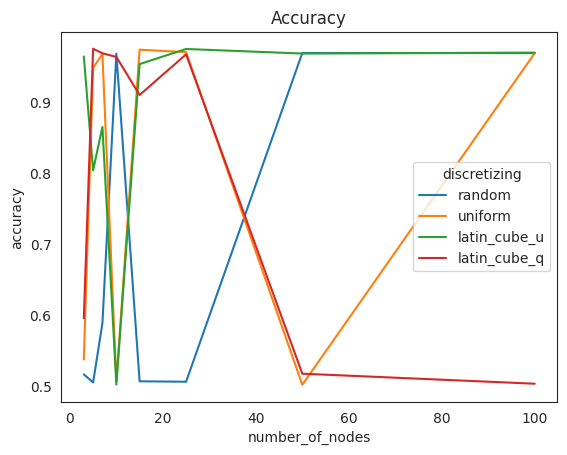

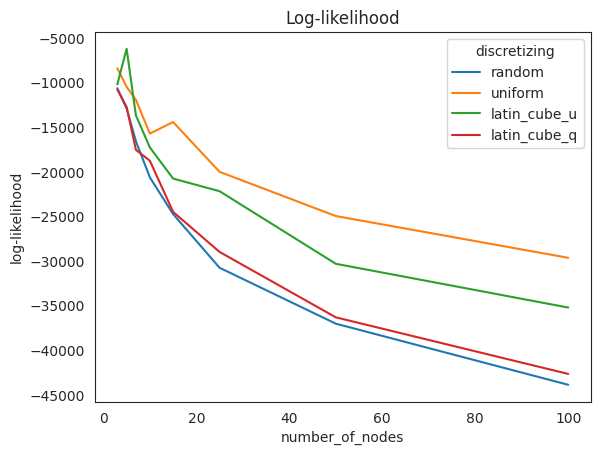

Recognized 1 instead of 3 states!
Recognized 2 instead of 3 states!


/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/kabalce/.local/lib/pyt

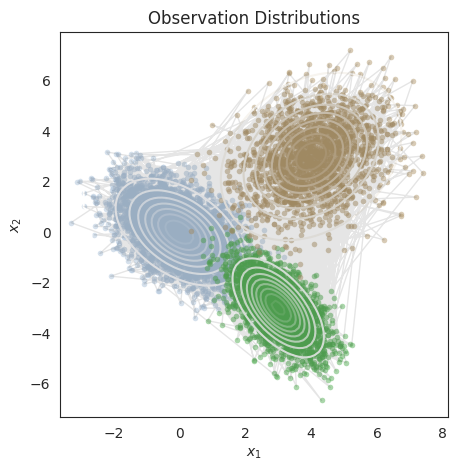

/tmp/ipykernel_54422/2508230348.py:60: RuntimeWarning: overflow encountered in exp
  'likelihood-ratio': np.exp(models[discretizing, number_of_nodes]['ll'] - target_ll)


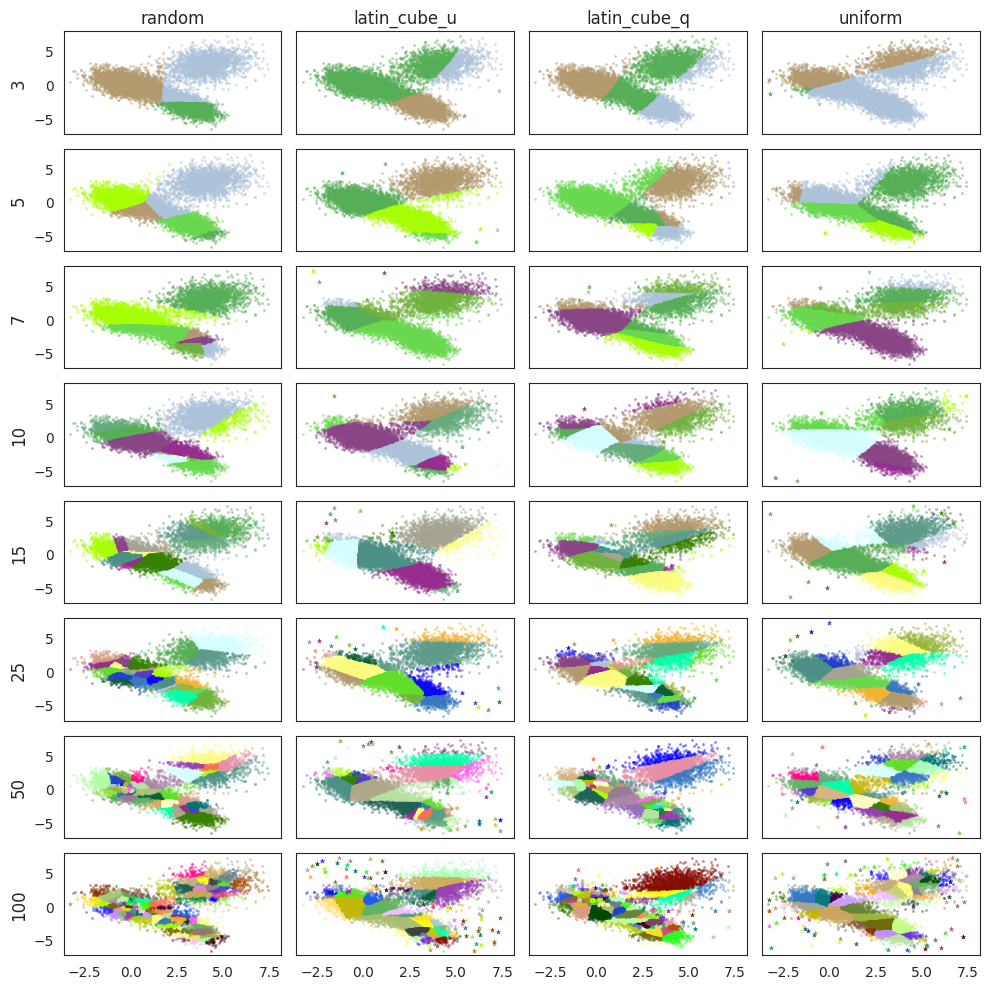

discretizing  number_of_nodes  accuracy  log-likelihood  likelihood-ratio
0         random                3    0.3929    -9734.235502               inf
24       uniform                3   -1.0000    -6190.607674               inf
32          None                3    0.9798   -36014.665851               0.0
8   latin_cube_u                3    0.7212    -8020.677525               inf
16  latin_cube_q                3    0.0780   -10353.676142               inf
33          None                5    0.9798   -36014.666302               0.0
17  latin_cube_q                5    0.6425   -12613.357425               inf
9   latin_cube_u                5    0.5992   -10394.234514               inf
25       uniform                5    0.5624   -13247.434116               inf
1         random                5    0.7036   -13493.710351               inf
34          None                7    0.9798   -36014.665961               0.0
2         random                7    0.3458   -15966.347533               inf
10  latin_cube_u                7    0.6660   -11941.825172               inf
26       uniform                7    0.0816   -12806.300765               inf
18  latin_cube_q                7    0.7290   -15560.221864               inf
27       uniform               10   -1.0000   -14301.671022               inf
35          None               10    0.5782   -38879.399410               0.0
19  latin_cube_q               10    0.6861   -19070.000079               inf
3         random               10    0.1064   -19524.343464               inf
11  latin_cube_u               10    0.5547   -14192.603193               inf
28       uniform               15    0.0779   -16770.941861               inf
20  latin_cube_q               15    0.9518   -21762.900989               inf
36          None               15    0.9798   -36014.665804               0.0
12  latin_cube_u               15    0.0168   -14603.931347               inf
4         random               15    0.3157   -25756.033016               inf
37          None               25    0.9798   -36014.665950               0.0
21  latin_cube_q               25    0.7114   -26832.018039               inf
13  latin_cube_u               25    0.6224   -18210.540645               inf
5         random               25    0.7486   -30566.408924               inf
29       uniform               25    0.2896   -22132.505126               inf
6         random               50    0.1568   -36470.680878               0.0
14  latin_cube_u               50    0.7406   -25227.859146               inf
30       uniform               50    0.3937   -29850.697868               inf
22  latin_cube_q               50    0.5480   -33461.231511               inf
38          None               50    0.0096   -36014.666122               0.0
15  latin_cube_u              100    0.6954   -27766.208585               inf
7         random              100    0.7436   -43778.138035               0.0
23  latin_cube_q              100    0.7044   -36204.275877               0.0
31       uniform              100    0.9473   -30346.423885               inf
39          None              100    0.9798   -36014.666352               0.0

/tmp/ipykernel_54422/2508230348.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


\begin{tabular}{llrrrr}
\toprule
{} &  discretizing &  number\_of\_nodes &  accuracy &  log-likelihood &  likelihood-ratio \\
\midrule
0  &        random &                3 &    0.3929 &    -9734.235502 &               inf \\
24 &       uniform &                3 &   -1.0000 &    -6190.607674 &               inf \\
32 &          None &                3 &    0.9798 &   -36014.665851 &               0.0 \\
8  &  latin\_cube\_u &                3 &    0.7212 &    -8020.677525 &               inf \\
16 &  latin\_cube\_q &                3 &    0.0780 &   -10353.676142 &               inf \\
33 &          None &                5 &    0.9798 &   -36014.666302 &               0.0 \\
17 &  latin\_cube\_q &                5 &    0.6425 &   -12613.357425 &               inf \\
9  &  latin\_cube\_u &                5 &    0.5992 &   -10394.234514 &               inf \\
25 &       uniform &                5 &    0.5624 &   -13247.434116 &               inf \\
1  &        random &                5 

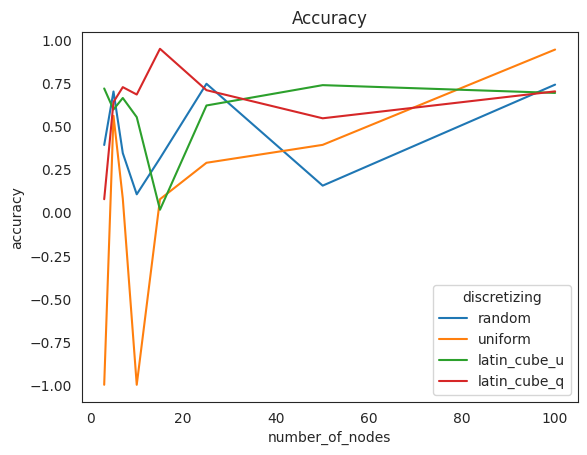

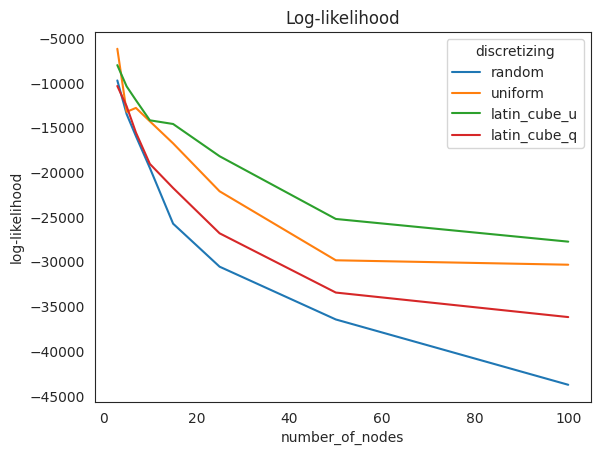

In [13]:
for sample_size in sample_sizes:
    print(f"sample_size = {sample_size}")
    evaluation(sample_size, 2)
    evaluation(sample_size, 3)

In [14]:
"Done"

'Done'